<a href="https://colab.research.google.com/github/larissavvsous/DeepLearning/blob/main/DL_Ext_Dep_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  **TL1 - Tarefas de Extração, Depuração e Análise de dados**

### **Dupla: Larissa Vitória Vasconcelos Sousa, Ruan Rodrigues Sousa**



---



#### **Você recebeu 7 conjuntos de dados brutos para análise.**

1. Os dados tem informações do total de
- Arquivos lidos e escritos em disco local na linha FILE BYTES READ/WRITTEN
- Arquivos lidos e escritos em disco HDFS na linha HDFS BYTES READ/WRITTEN

2. Cada job tem um formato de job: *job_201412151229_0002*

- Quando tem a função `Running` o tempo do job inicia e
- Quando tem a função `Job complete` o job finaliza

3. O tempo de início e fim de cada tarefa deve ser contabilizado pela subtração entre `"Job complete" - "Running"`

4. Deseja-se saber a
- quantidade média de dados lidos e escritos em disco local e HDFS e
- o tempo médio de execução de cada teste representado pelos datasets.

5. Tarefa
- Considere que você precisa depurar os dados
- Obter um dataset através de parser e
- Identificar se há alguma correlação entre as execuções.


#### **Com base nas instruções fornecidas, é necessário extrair as seguintes informações de cada linha do arquivo:**

- Tempo de início do job (quando ocorre a função Running).
- Tempo de fim do job (quando ocorre a função Job complete).
- Identificador do job (no formato job_YYYYMMDDHHMM_XXXX).
- Duração de cada job.
- Quantidade de dados lidos e escritos em disco local (informações encontradas na linha FILE BYTES READ/WRITTEN).
- Quantidade de dados lidos e escritos em disco HDFS (informações encontradas na linha HDFS BYTES READ/WRITTEN).

#### **Depois de extrair essas informações, é necessário calcular:**

- Tempo de execução de cada job (diferença entre o tempo de fim e o tempo de início).
- Quantidade média de dados lidos e escritos em disco local e HDFS.
- Tempo médio de execução de cada teste representado pelos datasets.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Bibliotecas

In [14]:
import pandas as pd
import re
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Parser

In [15]:
diretorio = '/content/drive/MyDrive/DeepLearning1a7' # usando a biblioteca glob, todos os arquivos dessa pasta vão ser percorridos
tipo_arquivo = '*.txt'

# Expressões para identificar padrões nas linhas
regex_inicio_job = re.compile(r'(\d{2}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}).+?Running job: (job_\d+_\d+)')
regex_fim_job = re.compile(r'(\d{2}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}).+?Job complete: (job_\d+_\d+)')
regex_bytes = re.compile(r'(FILE|HDFS)_BYTES_(READ|WRITTEN)=(\d+)')

dataset = [] # vai armazenar os dados extraídos de todos os jobs em todos os arquivos

for arquivo in glob.glob(f'{diretorio}/{tipo_arquivo}'): # vai obter uma lista de todos os arquivos no diretório
    inicio_jobs = []
    fim_jobs = []
    dados_local_read = None
    dados_local_written = None
    dados_hdfs_read = None
    dados_hdfs_written = None

    with open(arquivo, 'r') as f: # processando cada linha do arquivo aberto para conseguir extrair as informações desejadas
        for linha in f:
            match_inicio = regex_inicio_job.search(linha)
            match_fim = regex_fim_job.search(linha)
            if match_inicio:
                inicio_jobs.append((match_inicio.group(1), match_inicio.group(2)))
            elif match_fim:
                fim_jobs.append((match_fim.group(1), match_fim.group(2)))
            else:
                match_bytes = regex_bytes.search(linha)
                if match_bytes:
                    tipo = match_bytes.group(1)
                    acao = match_bytes.group(2).lower()
                    valor = int(match_bytes.group(3))
                    if tipo == 'FILE':
                        if acao == 'read':
                            dados_local_read = valor
                        elif acao == 'written':
                            dados_local_written = valor
                    elif tipo == 'HDFS':
                        if acao == 'read':
                            dados_hdfs_read = valor
                        elif acao == 'written':
                            dados_hdfs_written = valor

        for inicio, id_job in inicio_jobs: # calcular a duração de cada job completo
            for fim, id_fim in fim_jobs:
                if id_job == id_fim:
                    inicio_dt = datetime.strptime(inicio, "%d/%m/%y %H:%M:%S")
                    fim_dt = datetime.strptime(fim, "%d/%m/%y %H:%M:%S")
                    duracao_job = (fim_dt - inicio_dt).total_seconds()
                    dataset.append({
                        'inicio_job': inicio,
                        'fim_job': fim,
                        'id': id_job,
                        'dados_local_read': dados_local_read,
                        'dados_local_written': dados_local_written,
                        'duracao_job': duracao_job,  # em segundos
                        'dados_hdfs_read': dados_hdfs_read,
                        'dados_hdfs_written': dados_hdfs_written
                    })


## Convertendo para dataset

In [16]:
df = pd.DataFrame(dataset)

## Excluindo os caractereres "job_" da coluna ID

In [17]:
df['id'] = df['id'].str.replace('job_', '')

## Consolidando as colunas `'dados_local_read'` e `'dados_local_written'` em uma única coluna `'dados_local'`, e realizando o mesmo procedimento para os dados HDFS, resultando em uma única coluna `'dados_hdfs'`.

In [18]:
df['dados_local'] = df['dados_local_read'] + df['dados_local_written']
df['dados_hdfs'] = df['dados_hdfs_read'] + df['dados_hdfs_written']

df = df.drop(columns=['dados_local_read', 'dados_local_written', 'dados_hdfs_read', 'dados_hdfs_written'])

## Visualizando o dataset final

In [19]:
df

,inicio_job,fim_job,id,duracao_job,dados_local,dados_hdfs
0,14/12/15 13:49:45,14/12/15 13:50:43,201412151229_0001,58.0,20342969584,9450101644
1,14/12/15 13:50:55,14/12/15 13:51:40,201412151229_0002,45.0,20342969584,9450101644
2,14/12/15 13:51:57,14/12/15 13:52:38,201412151229_0003,41.0,20342969584,9450101644
3,14/12/15 13:53:50,14/12/15 13:54:44,201412151229_0004,54.0,20342969584,9450101644
4,14/12/15 13:55:19,14/12/15 13:56:02,201412151229_0005,43.0,20342969584,9450101644
...,...,...,...,...,...,...
127,14/12/15 23:12:59,14/12/15 23:13:40,201412152138_0026,41.0,40670069384,18886862240
128,14/12/15 23:15:21,14/12/15 23:16:42,201412152138_0027,81.0,40670069384,18886862240
129,14/12/15 23:18:23,14/12/15 23:19:05,201412152138_0028,42.0,40670069384,18886862240
130,14/12/15 23:20:46,14/12/15 23:21:26,201412152138_0029,40.0,40670069384,18886862240


#### **Após a depuração dos arquivos, o dataset foi obtido com as seguintes colunas:**

- `"id"`: identificador do job.
- `"inicio_job"`: início do job.
- `"fim_job"`: fim do job.
- `"dados_local"`: Quantidade de dados lidos e escritos (em bytes) a partir do disco local durante a execução do job.
- `"dados_hdfs"`: Quantidade de dados lidos e escritos (em bytes) a partir do sistema de arquivos distribuído HDFS (Hadoop Distributed File System) durante a execução do job.
- `"duracao_job"`: duração de cada job em segundos, subtração entre inicio_job e fim job.

## Verificando os tipos de dados

In [20]:
df.dtypes

inicio_job      object
fim_job         object
id              object
duracao_job    float64
dados_local      int64
dados_hdfs       int64
dtype: object

## Estatísticas descritivas

In [21]:
df.describe()

,duracao_job,dados_local,dados_hdfs
count,132.000000,1.320000e+02,1.320000e+02
mean,52.000000,3.174168e+10,1.474041e+10
std,20.932097,1.763664e+10,8.183493e+09
min,30.000000,2.034297e+10,9.450102e+09
25%,41.000000,2.034297e+10,9.450102e+09
50%,44.000000,2.034298e+10,9.450102e+09
75%,58.000000,4.067007e+10,1.888686e+10
max,116.000000,8.136286e+10,3.776038e+10


## Duração total

In [22]:
total_seg = df['duracao_job'].count()
total_seg = total_seg /60
print("O tempo total da execução foi de 132.0 segundos, ou seja,", total_seg, 'minutos.')

O tempo total da execução foi de 132.0 segundos, ou seja, 2.2 minutos.


## Calculando as médias

In [23]:
media_dados_local = df['dados_local'].mean()
print("Média de dados lidos e escritos em disco local:", media_dados_local)

media_dados_hdfs = df['dados_hdfs'].mean()
print("\nMédia de dados lidos e escritos em disco HDFS:", media_dados_hdfs)

media_duracao_job = df['duracao_job'].mean()
print("\nMédia de duração dos jobs:", media_duracao_job, "segundos")

Média de dados lidos e escritos em disco local: 31741681800.984848

Média de dados lidos e escritos em disco HDFS: 14740406341.598484

Média de duração dos jobs: 52.0 segundos


## Matriz de correlação

<ipython-input-24-32f8446cdbd0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacao = df.corr()


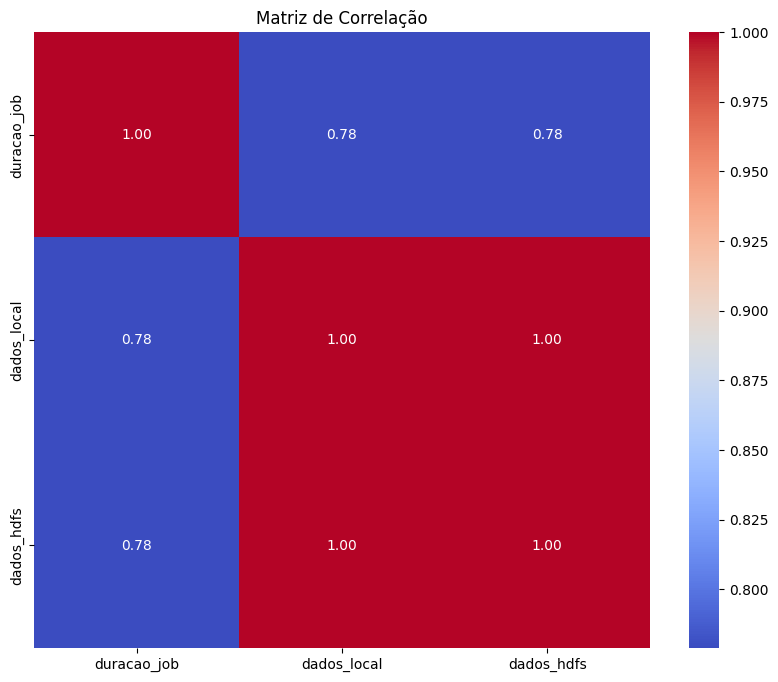

In [24]:
correlacao = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlação')
plt.show()

## Conclusão

#### Com base nessa análise, podemos observar que a média de dados lidos e escritos no disco local é muito maior do que a média de dados manipulados no disco HDFS. Além disso, a média da duração dos jobs é de aproximadamente 52 segundos. Ao analisar a matriz de correlação entre a duração dos jobs e o volume de dados lidos e escritos, observa-se uma forte correlação positiva entre elas, tanto para os dados locais quanto para os dados no HDFS. Isso mostra que, à medida que a quantidade de dados aumenta, a duração dos jobs tende a aumentar também.